## Import statements and loading the data

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

2025-05-10 15:28:33.368989: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
f = h5py.File('bird_spectrograms.hdf5', 'r')
list(f.keys())

['amecro',
 'amerob',
 'bewwre',
 'bkcchi',
 'daejun',
 'houfin',
 'houspa',
 'norfli',
 'rewbla',
 'sonspa',
 'spotow',
 'whcspa']

In [3]:
for key in list(f.keys()):
    print(f[key].shape)

(128, 517, 66)
(128, 517, 172)
(128, 517, 144)
(128, 517, 45)
(128, 517, 125)
(128, 517, 84)
(128, 517, 630)
(128, 517, 37)
(128, 517, 187)
(128, 517, 263)
(128, 517, 137)
(128, 517, 91)


In [4]:
# set seeds to ensure reproducibility 
np.random.seed(5322)
tf.random.set_seed(5322)
random.seed(5322)

## Binary Classification (Song Sparrow and House Sparrow)
- Just because these two species have the most samples in our dataset

In [5]:
# picked the two species with most samples for binary classifcation model
# sonspa = song sparrow, houspa = house sparrow
X1 = np.array(f['sonspa'])
X2 = np.array(f['houspa'])

In [6]:
# create labels. 0 for song sparrow, 1 for house sparrow
y1 = np.zeros(X1.shape[2])
y2 = np.ones(X2.shape[2])

In [7]:
# combine into one set
X = np.concatenate((X1, X2), axis = 2)
y = np.concatenate((y1, y2))

In [8]:
# X has shape (128, 517, total_samples)
# we need to format input like (total_samples, 128, 517, channels = 1 not 3 since not rgb)
X = np.transpose(X, (2, 0, 1))
X = X[..., np.newaxis]
# X is now (total_samples, 128, 517, 1)

In [9]:
# normalization before splitting into train and set sets to avoid data leakage
X = X.astype(np.float32)
X = X / np.max(X)

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5322, stratify = y)

## First simple model 7 total layers
- no l2 regularization yet
- no dropout
- (2, 2) max pooling to take max val of 2x2 windows
- flatten layer

In [11]:
# our first and simplest cnn for binary classification
model = Sequential([
    # layer group 1
    Conv2D(16, (3,3), activation = 'relu', input_shape = (128, 517, 1)),
    MaxPooling2D(2, 2),
    # layer group 2
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2, 2),
    # flatten layer
    Flatten(),
    # dense layers
    Dense(units = 64, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid')
], name = "Binary_Model_1")

# compile model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)

# model summary
model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

# train model
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

# test the model
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')
print(f'Test AUC: {test_auc}')

Model: "Binary_Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 515, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 257, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 255, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 127, 32)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 121920)            0         
                                                                 
 dense (Dense)               (None, 64)             

In [12]:
# predictions
y_pred_probs = model.predict(X_test)

# probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred, zero_division = 0, target_names = ['Song Sparrow', 'House Sparrow']))

6/6 [==============================] - 1s 179ms/step
               precision    recall  f1-score   support

 Song Sparrow       0.00      0.00      0.00        53
House Sparrow       0.70      1.00      0.83       126

     accuracy                           0.70       179
    macro avg       0.35      0.50      0.41       179
 weighted avg       0.50      0.70      0.58       179



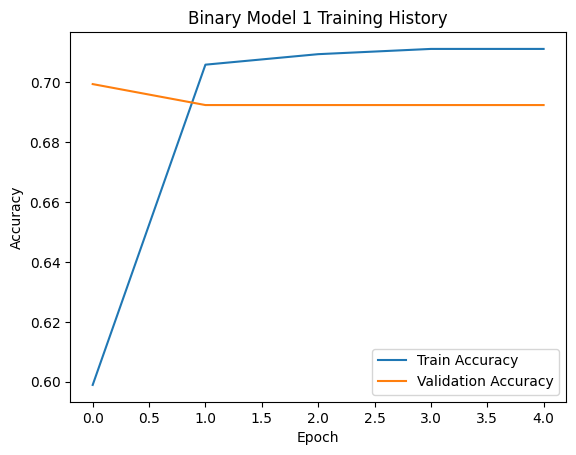

In [13]:
# visualize training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Binary Model 1 Training History')
plt.show()

In terms of just accuracy, this simple model does decent given its simplicity\
Looking deeper into the classifcation report, there is some class imbalance, which leads to no song sparrows being predicted\
The model did do well on the House Sparrow class which had more data samples. 100% recall and 70% precision is not bad given how basic and boilerplate the model is\
The 0.5 test AUC indicates it was random guessing as well\
Another important thing is the number of parameters in the dense layer. 7.8 million parameters is crazy given our dataset size, so add something like global average pooling 2d to reduce to a reasonable number\
Interesting how accuracy did not change, but the loss did slightly which did not allow early stopping\
Overall, decent simple model, but needs more complexity and tuning since the model stopped very early on

## Second model with improvements/adjustments 13 total layers
- added another layer "group" for complexity
- added 0.01 l2 regularization to discourage large weights
- added 30% dropout to help with overfitting and regularization
- also included global average pooling 2D instead of flatten to keep the number of parameters at each layer reasonable
- added early stopping since previous model converged early on
- also increased the number of epochs to allow the model to possibly improve accuracy

In [14]:
# our second cnn for binary classification
model = Sequential([
    # layer group 1
    Conv2D(16, (3, 3), activation = 'relu', input_shape = (128, 517, 1), kernel_regularizer = l2(0.01)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(rate = 0.3),
    # layer group 2
    Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = l2(0.01)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(rate = 0.3),
    # layer group 3
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.01)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(rate = 0.3),
    # pooling to keep # of parameters in check
    GlobalAveragePooling2D(),
    # dense layers
    Dense(units = 64, activation = 'relu', kernel_regularizer = l2(0.01)),
    Dropout(rate = 0.3),
    Dense(units = 1, activation = 'sigmoid')
], name = "Binary_Model_2")

# compile model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)

# model summary
model.summary()

# early stopping since previous model did not improve early on
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# train the model
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping],
)

# evaluate the model
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')
print(f'Test AUC: {test_auc}')

Model: "Binary_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 515, 16)      160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 257, 16)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 63, 257, 16)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 255, 32)       4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 127, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 127, 32)    

In [15]:
# predictions
y_pred_probs = model.predict(X_test)

# probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred, zero_division = 0, target_names = ['Song Sparrow', 'House Sparrow']))

6/6 [==============================] - 1s 98ms/step
               precision    recall  f1-score   support

 Song Sparrow       0.30      1.00      0.46        53
House Sparrow       0.00      0.00      0.00       126

     accuracy                           0.30       179
    macro avg       0.15      0.50      0.23       179
 weighted avg       0.09      0.30      0.14       179



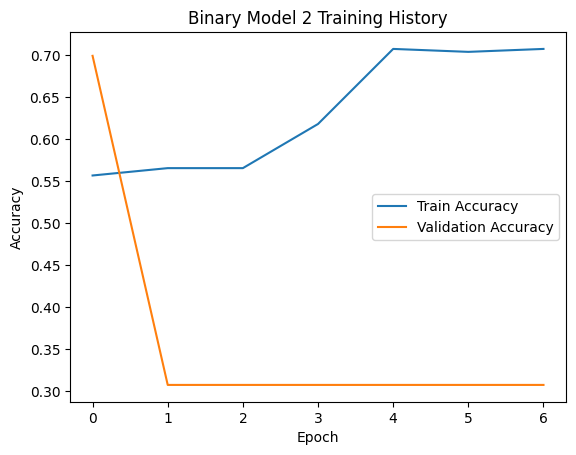

In [16]:
# visualize training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Binary Model 2 Training History')
plt.show()

Somehow did worse with adjustments in terms of accuracy and AUC. Might need to make more drastic tuning changes\
This model definitely overfit seen with the higher training accuracy and much lower validation accuracy\
The lack of improvement in validation accuracy also indicates the model is not learning well in the first place\
Performed worse than random guessing slightly\
At least this model made some predictions for both classes rather than just 1 of the 2\
Stopped very early on like the previous model\
Might need to add more layers for complexity\
Change regularization weight to try and prevent overfitting even more\
Maybe adjust dropout rate to scale with filter sizes

## Final binary model with even more improvements/adjustments 24 total layers version 1
- added a couple more layers for more complexity
- started the filter size at 32 instead of 16
- modified the dropouts at each layer to scale with filter sizes as they increase
- change l2 regularization to 0.0001 from 0.01 to prevent overfitting a little bit
- reduced the adam optimizer learning rate to allow for better convergence
- added batch normalization to stabilize and speed up training a little bit given we added more layers
- kept padding to be 'same' to retain more spatial information and details from our input as layer size increases. helps given small input sizes
- reduced stopping patience to 3 in case continous non improvement like previous model
- tried label smoothing so instead of comparing predictions with 0 and 1, it compares with 0.05 and 0.95

In [17]:
# final more complex cnn for binary classification with additional layers version 1
model = Sequential([
    # layer group 1
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 517, 1), kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # layer group 2
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # layer group 3
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    # layer group 4
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    # layer group 5
    Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    # keep # of params in check
    GlobalAveragePooling2D(),
    # dense layers
    Dense(units = 128, activation = 'relu', kernel_regularizer = l2(0.0001)),
    Dropout(0.4),
    Dense(units = 1, activation = 'sigmoid')
], name = "Binary_Model_3")

# compile the model with lower learning rate
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = BinaryCrossentropy(label_smoothing = 0.05),
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)

# model summary
model.summary()

# early stopping with some patience
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# train the model
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

# evaluate the model
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')
print(f'Test AUC: {test_auc}')

Model: "Binary_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 517, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 517, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 258, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64, 258, 32)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 258, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 258, 64)    

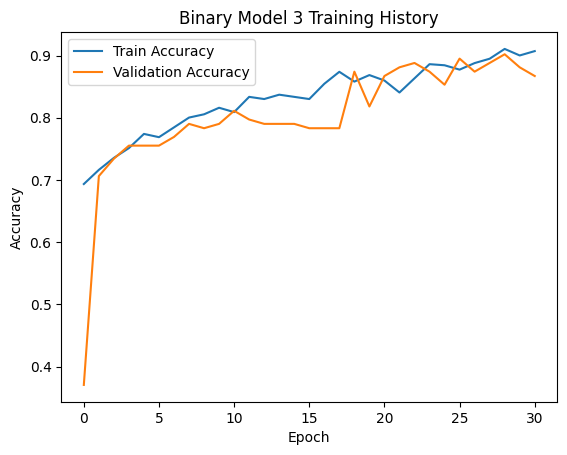

In [18]:
# visualize training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Binary Model 3 Training History')
plt.show()

In [19]:
# predictions
y_pred_probs = model.predict(X_test)

# probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred, zero_division = 0, target_names = ['Song Sparrow', 'House Sparrow']))

6/6 [==============================] - 4s 663ms/step
               precision    recall  f1-score   support

 Song Sparrow       0.88      0.70      0.78        53
House Sparrow       0.88      0.96      0.92       126

     accuracy                           0.88       179
    macro avg       0.88      0.83      0.85       179
 weighted avg       0.88      0.88      0.88       179



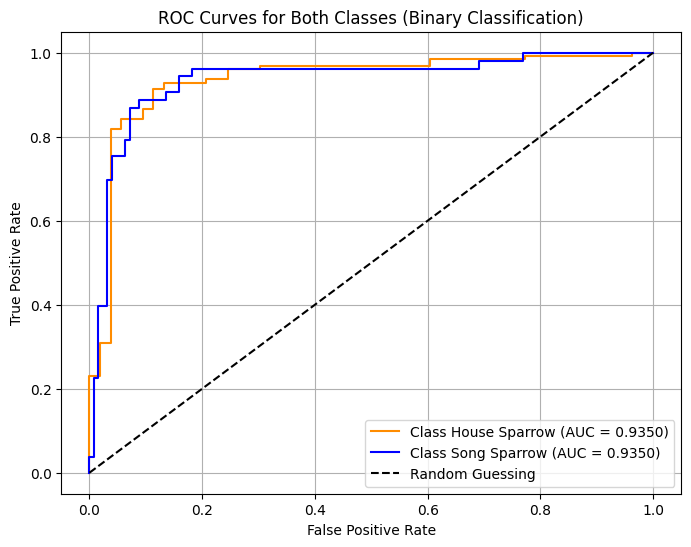

In [20]:
# predicted probabilities
y_scores = y_pred_probs.ravel()

# ROC for class 1 house sparrow
fpr1, tpr1, _ = roc_curve(y_test, y_scores)
auc1 = auc(fpr1, tpr1)

# ROC for class 0 song sparrow
fpr0, tpr0, _ = roc_curve(1 - y_test, 1 - y_scores)
auc0 = auc(fpr0, tpr0)

# plot both
plt.figure(figsize = (8, 6))
plt.plot(fpr1, tpr1, label = f'Class House Sparrow (AUC = {auc1:.4f})', color = 'darkorange')
plt.plot(fpr0, tpr0, label = f'Class Song Sparrow (AUC = {auc0:.4f})', color = 'blue')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Both Classes (Binary Classification)')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

Much more stable model with much better accuracy than previous 2 with the gradual and progressive learning\
Decent accuracy --> ~88% on test set\
AUC is great --> 0.935\
Precision and recall for both classes is great as well\
Model generalizes well and stop early\
This model does a much better job at predicting both classes but could do better for song sparrow maybe\
Seems the additional layers, the label smoothing, lower l2 regularization, scaling dropout, same padding, batch normalization, and smaller learning rate helped improve the model significantly\
No signs of overfitting either which is amazing

## Final binary model with even more improvements/adjustments 24 total layers version 2
- only difference is the batch size. 16 --> 32
- given we only had a couple thousand samples, 16 or 32 seemed like a reasonable choice
- wanted to see if higher batch size helps

In [21]:
# final more complex cnn for binary classification with additional layers version 2
model = Sequential([
    # layer group 1
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 517, 1), kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # layer group 2
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # layer group 3
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    # layer group 4
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    # layer group 5
    Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = l2(0.0001), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    # keep # of params in check
    GlobalAveragePooling2D(),
    # dense layers
    Dense(units = 128, activation = 'relu', kernel_regularizer = l2(0.0001)),
    Dropout(0.4),
    Dense(units = 1, activation = 'sigmoid')
], name = "Binary_Model_4")

# compile the model with lower learning rate
model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = BinaryCrossentropy(label_smoothing = 0.05),
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)

# model summary
model.summary()

# early stopping with some patience
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# train the model
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

# evaluate the model
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc}')
print(f'Test AUC: {test_auc}')

Model: "Binary_Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 517, 32)      320       
                                                                 
 batch_normalization_5 (Bat  (None, 128, 517, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 258, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 64, 258, 32)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 258, 64)       18496     
                                                                 
 batch_normalization_6 (Bat  (None, 64, 258, 64)    

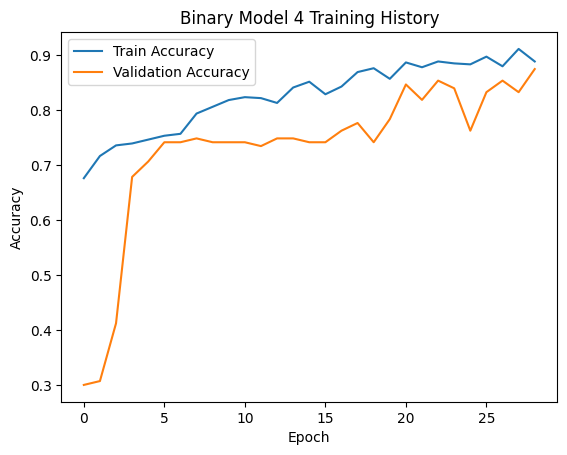

In [22]:
# visualize training accuracy versus validation accuracy
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Binary Model 4 Training History')
plt.show()

In [23]:
# predictions
y_pred_probs = model.predict(X_test)

# probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred, zero_division = 0, target_names = ['Song Sparrow', 'House Sparrow']))

6/6 [==============================] - 4s 666ms/step
               precision    recall  f1-score   support

 Song Sparrow       0.93      0.49      0.64        53
House Sparrow       0.82      0.98      0.90       126

     accuracy                           0.84       179
    macro avg       0.87      0.74      0.77       179
 weighted avg       0.85      0.84      0.82       179



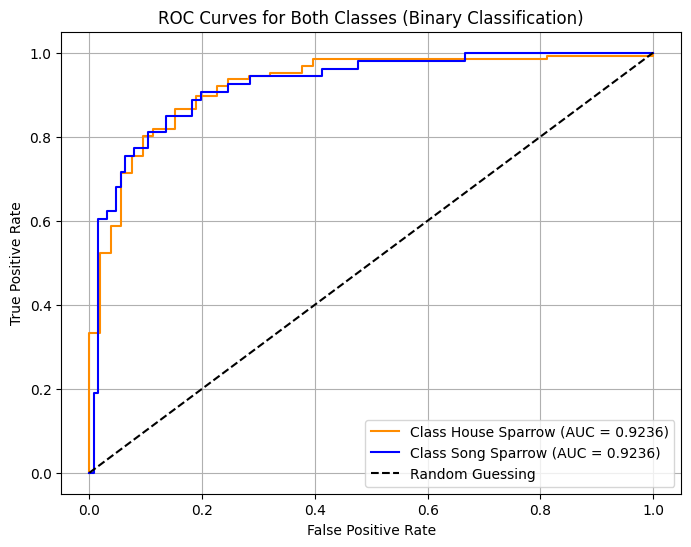

In [24]:
# predicted probabilities
y_scores = y_pred_probs.ravel()

# ROC for class 1 house sparrow
fpr1, tpr1, _ = roc_curve(y_test, y_scores)
auc1 = auc(fpr1, tpr1)

# ROC for class 0 song sparrow
fpr0, tpr0, _ = roc_curve(1 - y_test, 1 - y_scores)
auc0 = auc(fpr0, tpr0)

# plot both
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label = f'Class House Sparrow (AUC = {auc1:.4f})', color = 'darkorange')
plt.plot(fpr0, tpr0, label = f'Class Song Sparrow (AUC = {auc0:.4f})', color = 'blue')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Both Classes (Binary Classification)')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

Did slightly worse that batch size 16. Seems a smaller batch size works better with a smaller dataset\
Accuracy and AUC is decent as well. Slightly lower than with the 16 batch size but still pretty decent\
Recall for song sparrow was pretty low\
There could be slight overfitting, but for the most part, it seems there was little no overfitting overall, which is good\
Probably gonna stick with batch size of 16